# Alkım Ege Akarsu | 21901461 | CS 464 | HW2 | Q3

## Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.svm import SVC

SEED = 0
np.random.seed(SEED)

## Functions

In [2]:
def standardize(X_train, X_test):
    """Standardize train, and test sets.

    Args:
        X_train (ndarray): Training set.
        X_test (ndarray): Test set.
    """
    # Get mean and std of training set
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    # Use mean and std on all sets to standardize
    X_train = (X_train - mean) / (std + 1e-7)
    X_test = (X_test - mean) / (std + 1e-7)
    
    return X_train, X_test


def select_C(X_train, y_train, C_list):
    # Current C error list
    error_storage = np.zeros(10)
    # Initialize average error storage
    avg_errors = {C: 0 for C in C_list}
    # Loop over possible C values
    for C in C_list:
        for i in range(10):
            # Shuffle training set
            random_indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[random_indices], y_train[random_indices]
            # Get first 15%-25% of training set as validation set
            val_multiplier = np.random.randint(15, 26) / 100
            val_index = int(X_train.shape[0] * val_multiplier)
            X_val, y_val = X_train[:val_index], y_train[:val_index]
            X_train_cv, y_train_cv = X_train[val_index:], y_train[val_index:]
            # Train model
            model = SVC(C=C, kernel="linear", shrinking=False, random_state=SEED)
            model.fit(X_train_cv, y_train_cv)
            # Get validation error
            error_storage[i] = 1 - model.score(X_val, y_val)
        # Store average error
        avg_errors[C] = np.mean(error_storage)
    # Get best C value
    best_C = min(avg_errors, key=avg_errors.get)
    return best_C, avg_errors


def select_C_d(X_train, y_train, C_list, d_list):
    # Current C error list
    temp_error_storage = np.zeros(10)
    # Initialize average error storage
    avg_errors = np.ndarray((C_list.shape[0], d_list.shape[0]))
    # Loop over possible C values
    for j, C in enumerate(C_list):
        # Loop over possible d values
        for k, d in enumerate(d_list):
            # 10 iterations of cv
            for i in range(10):
                # Shuffle training set
                random_indices = np.random.permutation(X_train.shape[0])
                X_train, y_train = X_train[random_indices], y_train[random_indices]
                # Get first 15%-25% of training set as validation set
                val_multiplier = np.random.randint(15, 26) / 100
                val_index = int(X_train.shape[0] * val_multiplier)
                X_val, y_val = X_train[:val_index], y_train[:val_index]
                X_train_cv, y_train_cv = X_train[val_index:], y_train[val_index:]
                # Train model
                model = SVC(C=C, kernel="poly", degree=d, shrinking=False, random_state=SEED)
                model.fit(X_train_cv, y_train_cv)
                # Get validation error
                temp_error_storage[i] = 1 - model.score(X_val, y_val)
            # Store average error
            avg_errors[j][k] = np.mean(temp_error_storage)
    # Get best C and d values
    best_C_d_index = np.unravel_index(avg_errors.argmin(), avg_errors.shape)
    best_C_d = (C_list[best_C_d_index[0]], d_list[best_C_d_index[1]])
    return best_C_d, avg_errors


def get_confusion_matrix(y_true, y_pred):
    """Calculate confusion matrix for performance evaluation.

    Args:
        y_true (ndarray): Array of true labels.
        y_pred (ndarray): Array of predicted labels.

    Returns:
        ndarray: Confusion matrix
        TN FP
        FN TP
    """
    result = np.zeros((2, 2))

    for i in range(y_true.shape[0]):
        result[y_true[i]][y_pred[i]] += 1

    return result


def get_accuracy(y_true, y_pred):
    """Calculate accuracy for performance evaluation.

    Args:
        y_true (ndarray): Array of true labels.
        y_pred (ndarray): Array of predicted labels.

    Returns:
        double: Accuracy metric.
    """
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    
    return (TP + TN) / (TP + TN + FP + FN)


def get_precision(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TP / (TP + FP)
    elif mode == "macro":
        return ((TP1 / (TP1 + FP1)) + (TP0 / (TP0 + FP0))) / 2
    elif mode == "micro":
        return (TP1 + TP0) / (TP1 + TP0 + FP1 + FP0)
    else:
        print("ERROR: Invalid mode")

def get_recall(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TP / (TP + FN)
    elif mode == "macro":
        return ((TP1 / (TP1 + FN1)) + (TP0 / (TP0 + FN0))) / 2
    elif mode == "micro":
        return (TP1 + TP0) / (TP1 + TP0 + FN1 + FN0)
    else:
        print("ERROR: Invalid mode")


def get_negative_predictive_value(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TN / (TN + FN)
    elif mode == "macro":
        return ((TN1 / (TN1 + FN1)) + (TN0 / (TN0 + FN0))) / 2
    elif mode == "micro":
        return (TN1 + TN0) / (TN1 + TN0 + FN1 + FN0)
    else:
        print("ERROR: Invalid mode")


def get_false_positive_rate(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return FP / (FP + TN)
    elif mode == "macro":
        return ((FP1 / (FP1 + TN1)) + (FP0 / (FP0 + TN0))) / 2
    elif mode == "micro":
        return (FP1 + FP0) / (FP1 + FP0 + TN1 + TN0)
    else:
        print("ERROR: Invalid mode")


def get_false_discovery_rate(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return FP / (FP + TP)
    elif mode == "macro":
        return ((FP1 / (FP1 + TP1)) + (FP0 / (FP0 + TP0))) / 2
    elif mode == "micro":
        return (FP1 + FP0) / (FP1 + FP0 + TP1 + TP0)
    else:
        print("ERROR: Invalid mode")


def get_f1_score(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return (2 * TP) / ((2 * TP) + FP + FN)
    elif mode == "macro":
        return (((2 * TP1) / ((2 * TP1) + FP1 + FN1)) + ((2 * TP0) / ((2 * TP0) + FP0 + FN0))) / 2
    elif mode == "micro":
        return ((2 * TP1) + (2 * TP0)) / (((2 * TP1) + FP1 + FN1) + ((2 * TP0) + FP0 + FN0))
    else:
        print("ERROR: Invalid mode")


def get_f2_score(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TP / (TP + (0.2 * FP) + (0.8 * FN))
    elif mode == "macro":
        return ((TP1 / (TP1 + (0.2 * FP1) + (0.8 * FN1))) + (TP0 / (TP0 + (0.2 * FP0) + (0.8 * FN0)))) / 2
    elif mode == "micro":
        return (TP1 + TP0) / ((TP1 + (0.2 * FP1) + (0.8 * FN1)) + (TP0 + (0.2 * FP0) + (0.8 * FN0)))
    else:
        print("ERROR: Invalid mode")


def get_evaluations(y_true, y_pred):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    acc = get_accuracy(y_true, y_pred)
    precision_binary = get_precision(y_true, y_pred, "binary")
    precision_macro = get_precision(y_true, y_pred, "macro")
    precision_micro = get_precision(y_true, y_pred, "micro")
    recall_binary = get_recall(y_true, y_pred, "binary")
    recall_macro = get_recall(y_true, y_pred, "macro")
    recall_micro = get_recall(y_true, y_pred, "micro")
    npv_binary = get_negative_predictive_value(y_true, y_pred, "binary")
    npv_macro = get_negative_predictive_value(y_true, y_pred, "macro")
    npv_micro = get_negative_predictive_value(y_true, y_pred, "micro")
    fpr_binary = get_false_positive_rate(y_true, y_pred, "binary")
    fpr_macro = get_false_positive_rate(y_true, y_pred, "macro")
    fpr_micro = get_false_positive_rate(y_true, y_pred, "micro")
    fdr_binary = get_false_discovery_rate(y_true, y_pred, "binary")
    fdr_macro = get_false_discovery_rate(y_true, y_pred, "macro")
    fdr_micro = get_false_discovery_rate(y_true, y_pred, "micro")
    f1_binary = get_f1_score(y_true, y_pred, "binary")
    f1_macro = get_f1_score(y_true, y_pred, "macro")
    f1_micro = get_f1_score(y_true, y_pred, "micro")
    f2_binary = get_f2_score(y_true, y_pred, "binary")
    f2_macro = get_f2_score(y_true, y_pred, "macro")
    f2_micro = get_f2_score(y_true, y_pred, "micro")
    # Print evaluations
    print(f"Confusion matrix: TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}")
    print(f"Accuracy: {acc}")
    print(f"Precision (binary): {precision_binary}")
    print(f"Precision (macro): {precision_macro}")
    print(f"Precision (micro): {precision_micro}")
    print(f"Recall (binary): {recall_binary}")
    print(f"Recall (macro): {recall_macro}")
    print(f"Recall (micro): {recall_micro}")
    print(f"NPV (binary): {npv_binary}")
    print(f"NPV (macro): {npv_macro}")
    print(f"NPV (micro): {npv_micro}")
    print(f"FPR (binary): {fpr_binary}")
    print(f"FPR (macro): {fpr_macro}")
    print(f"FPR (micro): {fpr_micro}")
    print(f"FDR (binary): {fdr_binary}")
    print(f"FDR (macro): {fdr_macro}")
    print(f"FDR (micro): {fdr_micro}")
    print(f"F1 (binary): {f1_binary}")
    print(f"F1 (macro): {f1_macro}")
    print(f"F1 (micro): {f1_micro}")
    print(f"F2 (binary): {f2_binary}")
    print(f"F2 (macro): {f2_macro}")
    print(f"F2 (micro): {f2_micro}")

## Support Vector Machines

In [3]:
# Get dataset directories
train_path = Path().resolve().joinpath("datasets", "Spambase_train.csv")
test_path = Path().resolve().joinpath("datasets", "Spambase_test.csv")
# Load datasets
train = pd.read_csv(train_path, sep="\t")
test = pd.read_csv(test_path, sep="\t")
# Get X and y values
y_train, y_test = train["Class"], test["Class"]
X_train, X_test = train.drop(columns="Class"), test.drop(columns="Class")
# Convert all DataFrames to numpy arrays
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
# Standardize X values
X_train, X_test = standardize(X_train, X_test)

### 3.1

Confusion matrix: TN, FP, TP, FN: 46.0, 4.0, 45.0, 5.0
Accuracy: 0.91
Precision (binary): 0.9183673469387755
Precision (macro): 0.9101640656262505
Precision (micro): 0.91
Recall (binary): 0.9
Recall (macro): 0.91
Recall (micro): 0.91
NPV (binary): 0.9019607843137255
NPV (macro): 0.9101640656262505
NPV (micro): 0.91
FPR (binary): 0.08
FPR (macro): 0.09
FPR (micro): 0.09
FDR (binary): 0.08163265306122448
FDR (macro): 0.0898359343737495
FDR (micro): 0.09
F1 (binary): 0.9090909090909091
F1 (macro): 0.90999099909991
F1 (micro): 0.91
F2 (binary): 0.9036144578313253
F2 (macro): 0.9099745595929535
F2 (micro): 0.91


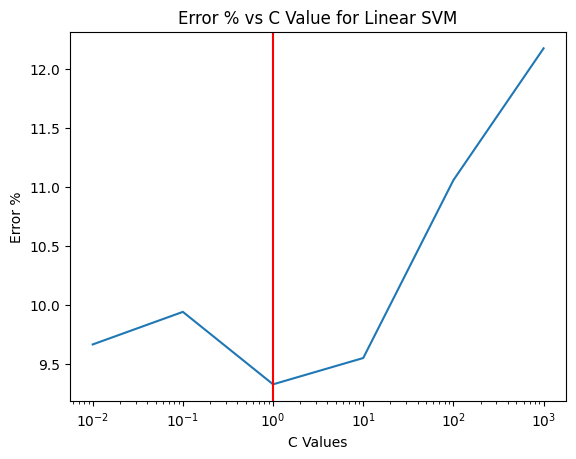

In [4]:
# Find best C value in list of C values
C_list = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
best_C, avg_errors = select_C(X_train, y_train, C_list)
# Plot error vs C
plt.figure()
plt.title("Error % vs C Value for Linear SVM")
plt.xlabel("C Values")
plt.ylabel("Error %")
plt.xscale("log")
plt.plot(list(avg_errors.keys()), np.array(list(avg_errors.values())) * 100)
plt.axvline(x=best_C, color="red")

# Train model using best C value
model = SVC(C=best_C, kernel="linear", shrinking=False, random_state=SEED)
model.fit(X_train, y_train)
# Predict the test set
y_pred = model.predict(X_test)
# Get evaluations
get_evaluations(y_test, y_pred)

### 3.2

Confusion matrix: TN, FP, TP, FN: 44.0, 6.0, 47.0, 3.0
Accuracy: 0.91
Precision (binary): 0.8867924528301887
Precision (macro): 0.9114813327980731
Precision (micro): 0.91
Recall (binary): 0.94
Recall (macro): 0.9099999999999999
Recall (micro): 0.91
NPV (binary): 0.9361702127659575
NPV (macro): 0.9114813327980731
NPV (micro): 0.91
FPR (binary): 0.12
FPR (macro): 0.09
FPR (micro): 0.09
FDR (binary): 0.11320754716981132
FDR (macro): 0.08851866720192694
FDR (micro): 0.09
F1 (binary): 0.912621359223301
F1 (macro): 0.9099189270343309
F1 (micro): 0.91
F2 (binary): 0.9288537549407114
F2 (macro): 0.9097710070250116
F2 (micro): 0.91


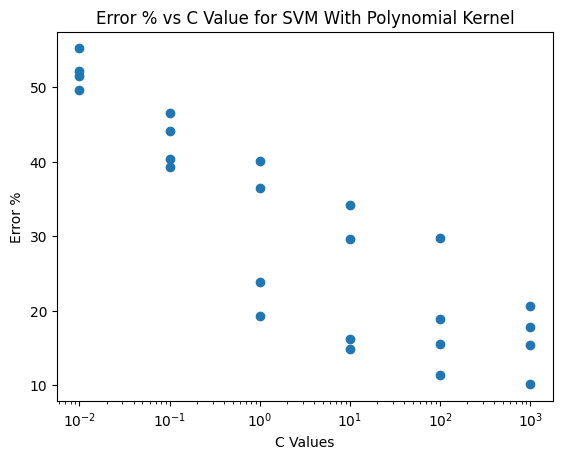

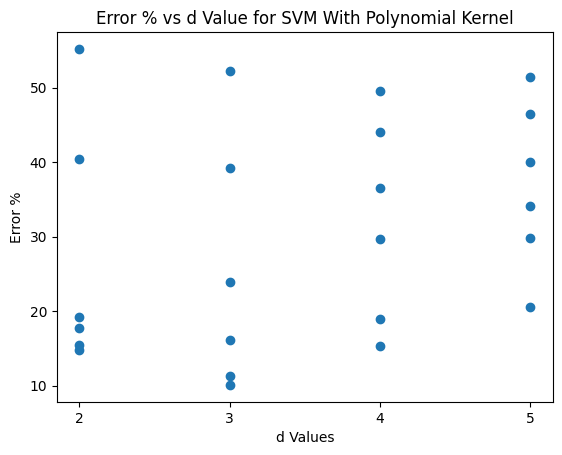

In [6]:
# Find best C and d values
C_list = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
d_list = np.array([2, 3, 4, 5])
best_C_d, avg_errors = select_C_d(X_train, y_train, C_list, d_list)
# Plot error vs C
x = np.repeat(C_list, d_list.shape[0])
y = np.tile(d_list, C_list.shape[0])
z = avg_errors.flatten() * 100
plt.figure()
plt.title("Error % vs C Value for SVM With Polynomial Kernel")
plt.xlabel("C Values")
plt.ylabel("Error %")
plt.xscale("log")
plt.scatter(x, z)
# Plot error vs d
plt.figure()
plt.title("Error % vs d Value for SVM With Polynomial Kernel")
plt.xlabel("d Values")
plt.ylabel("Error %")
plt.xticks(d_list)
plt.scatter(y, z)

# Train model using best C value
model = SVC(C=best_C_d[0], kernel="poly", degree=best_C_d[1], shrinking=False, random_state=SEED)
model.fit(X_train, y_train)
# Predict the test set
y_pred = model.predict(X_test)
# Get evaluations
get_evaluations(y_test, y_pred)